In [1]:
 %load_ext autoreload

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  TensorBoard
from tensorflow.keras.applications import EfficientNetB0
# from tqdm.auto import tqdm
from time import  time
from tabulate import tabulate
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt


In [16]:
import tensorflow_similarity as tfsim
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.losses import TripletLoss, CircleLoss, PNLoss
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.models import SimilarityModel
from tensorflow_similarity.samplers import MultiShotMemorySampler
from tensorflow_similarity.samplers import select_examples
from tensorflow_similarity.visualization import viz_neigbors_imgs

In [4]:
print('tf', tf.__version__)
print('tfsim', tfsim.__version__)
tf_cap_memory()

tf 2.5.0
tfsim 0.13.2


# Preparing data
To demonstrate the ability of single-shot learning, we are going to train 
**fixme**


an index that contains a few examples of both even and odd digits to show how the model is able to do matching on 
unseen classes with few examples.


Note: Tensorflow similarity expect y_train to be the examples class as integer so there is no need for processing

In [5]:
NUM_TRAINING_CLASSES = 80  # max is 100 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

# x_train = tf.constant(x_train / 255.0, dtype='float32')
# x_test = tf.constant(x_test / 255.0, dtype='float32')

# we need to reshape the Y to have a 1d array
y_train = tf.squeeze(y_train)
y_test = tf.squeeze(y_test)
print(x_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000,)


In [6]:
# select examples only for the first n classes
training_classes = list(range(NUM_TRAINING_CLASSES))
x_restricted, y_restricted = select_examples(x_train, y_train, training_classes, 600)
print(x_restricted.shape, y_restricted.shape)

(48000, 32, 32, 3) (48000,)


In [8]:
CLASS_PER_BATCH = 16 #@param {type:"integer"}
EXAMPLE_PER_CLASS = 2 #@param {type:"integer"}
sampler = MultiShotMemorySampler(x_restricted, y_restricted, class_per_batch=CLASS_PER_BATCH, example_per_class=EXAMPLE_PER_CLASS)

indexing classes:   5%|▌         | 2627/48000 [00:00<00:03, 13017.13it/s]


Batch size is 32 (16 class X 2 example per class pre-augmentation


indexing classes: 100%|██████████| 48000/48000 [00:03<00:00, 13246.86it/s]


In [9]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(),
        layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
        layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

In [10]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    return x

def get_model(input_shape=(32, 32, 3)):
    tf.keras.backend.clear_session()
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = EfficientNetB0(input_shape=input_shape, include_top=False)(x)

    # x = conv_block(x, 16)  
    # x = conv_block(x, 32)
    # x = conv_block(x, 64)
    # x = conv_block(x, 128)
    # x = conv_block(x, 256)
    x = layers.GlobalMaxPool2D()(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = MetricEmbedding(16)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1, 1, 1280)        4049571   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)         

In [17]:
distance = 'cosine' #@param ["cosine"]{allow-input: false}
positive_mining_strategy = 'hard' #@param ["easy", "hard"]{allow-input: false}
negative_mining_strategy = 'semi-hard' #@param ["easy", "hard"]{allow-input: false}
triplet_loss = TripletLoss(distance=distance,
    positive_mining_strategy=positive_mining_strategy,
    negative_mining_strategy=negative_mining_strategy)
circle_loss = CircleLoss(distance=distance)
pn_loss = PNLoss(distance=distance)

In [18]:
STEPS_PER_EXECUTION = 3  # speedup execution by grouping batchs
model = get_model()
optimizer = Adam(0.002)
model.compile(optimizer=optimizer, steps_per_execution=STEPS_PER_EXECUTION, loss=pn_loss)

Distance metric automatically set to cosine use the distance arg to override.


In [19]:
EPOCHS = 5 #@param{Integer}
history = model.fit(sampler, validation_data=(x_test, y_test), epochs=EPOCHS)

Epoch 1/5


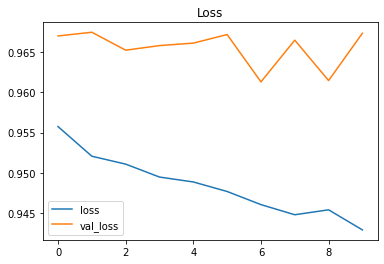

In [18]:
# let's visualizing loss overtime
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.show()

In [19]:
NUM_EXAMPLE_PER_CLASS = 50
x_index, y_index = select_examples(x_train, y_train, list(range(100)), NUM_EXAMPLE_PER_CLASS)

In [21]:
model.reset_index()
model.index(x_index, y_index)

[Indexing 5000 points]
|-Computing embeddings
|-Storing data points in index table
|-Adding embeddings to fast NN matcher index.
|-Optimizing NN matcher index.


Expected label: 36
  label    distances
-------  -----------
     45   6.4671e-05
     24   0.0010128
     88   0.00103259
      7   0.00107962
     66   0.00168419 



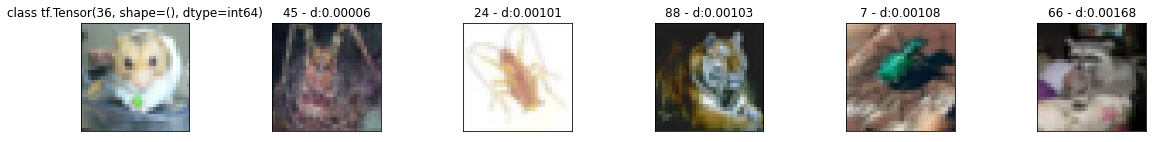

In [23]:
# query the closest points in our index for ALL 10000 test examples
num_neighboors = 5
test_id = 160  # 78 is a 9 a class we never trained on

# query closest matches
neighboors = model.single_lookup(x_test[test_id], k=num_neighboors)

# display results in tabular format
rows = [[n.label, n.distance] for n in neighboors]
print('Expected label: %d' % y_test[test_id])
print(tabulate(rows, headers=['label', 'distances']), '\n')

# view results close by
viz_neigbors_imgs(x_test[test_id], y_test[test_id], neighboors, fig_size=(20, 2))

In [24]:
model.index_summary()

[Info]
------------------  -----------
distance            cosine
index table         memory
matching algorithm  nmslib_hnsw
evaluator           memory
index size          5000
calibrated          False
calibration_metric  f1_score
embedding_output
------------------  -----------



[Performance]
-----------  -----------
num lookups  2
min          6.41346e-05
max          8.91685e-05
avg          7.66516e-05
median       7.66516e-05
stddev       1.2517e-05
-----------  -----------


In [25]:
num_calibration_samples = 200
calibration = model.calibrate(x_train
[:num_calibration_samples], y_train[:num_calibration_samples], k=3)

Finding NN:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

computing thresholds:   0%|          | 0/1000 [00:00<?, ?it/s]


 name       value    distance    accuracy    recall    f1_score
-------  -------  ----------  ----------  --------  ----------
optimal     0.18   0.0198594         0.1       0.9        0.18


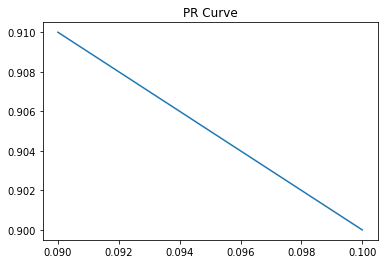

In [27]:
plt.plot(calibration['thresholds']['accuracy'], calibration['thresholds']['recall'])
plt.title("PR Curve")
plt.show()

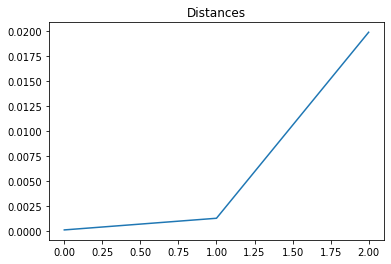

In [28]:
plt.plot(calibration['thresholds']['distance'])
plt.title("Distances")
plt.show()

In [32]:
rows = []
thresholds = calibration['thresholds']
for idx in range(len(thresholds['distance'])):
    rows.append([thresholds['distance'][idx], thresholds['accuracy'][idx], thresholds['recall'][idx]])

print(tabulate(rows, headers=['distance', 'precision', 'recall']))

  distance    precision    recall
----------  -----------  --------
0.00013077        0.09      0.91
0.00129414        0.095     0.905
0.0198594         0.1       0.9
